<a href="https://colab.research.google.com/github/talesoverfables/NetShield/blob/main/models/RFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset downloaded to: /kaggle/input/iot23-dataset
Found 2 CSV files in the dataset
Using file: /kaggle/input/iot23-dataset/cleaned_data.csv
Dataset shape: (48003, 25)

First few rows:
     duration  orig_bytes  resp_bytes  missed_bytes  orig_pkts  orig_ip_bytes  \
0    0.003497           0           0           0.0        5.0          212.0   
1    0.036724          34         311           0.0        1.0           62.0   
2  384.518261       15072           0           0.0       48.0        16416.0   
3    0.270332          48          48           0.0        1.0           76.0   
4    0.111429          48          48           0.0        1.0           76.0   

   resp_pkts  resp_ip_bytes   label  proto_icmp  ...  conn_state_RSTOS0  \
0        3.0          144.0  Benign           0  ...                  0   
1        1.0          339.0  Benign           0  ...                  0   
2        0.0            0.0  Benign           0  ...                  0   
3        1.0           76.0 

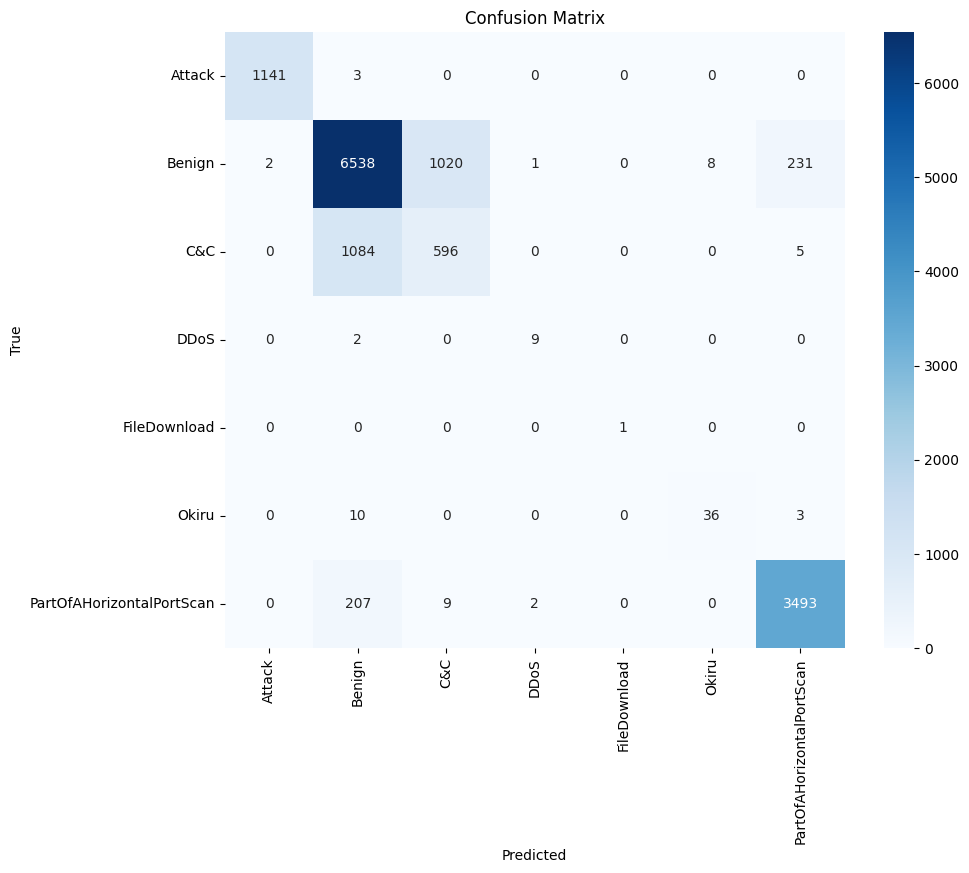

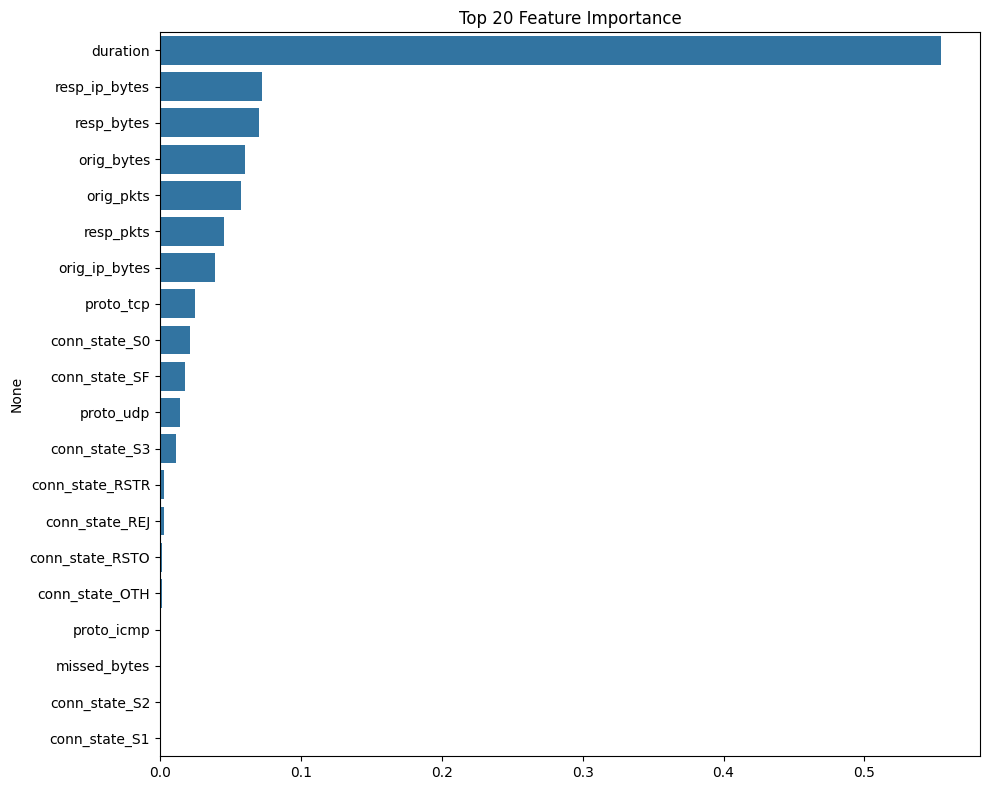

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import kagglehub
import zipfile
import glob

# Download the IoT23 dataset from Kaggle
print("Downloading IoT23 dataset from Kaggle...")
path = kagglehub.dataset_download("astralfate/iot23-dataset")
print(f"Dataset downloaded to: {path}")

# Get all CSV files in the dataset
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found {len(csv_files)} CSV files in the dataset")

# For a baseline model, let's take a sample of the data
# We'll use the first CSV file for simplicity
if csv_files:
    print(f"Using file: {csv_files[0]}")

    # Load the data
    df = pd.read_csv(csv_files[0])
    print(f"Dataset shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Basic dataset info
    print("\nBasic dataset info:")
    print(df.info())

    # Summary statistics
    print("\nSummary statistics:")
    print(df.describe())

    # Data preprocessing
    print("\nPreprocessing data...")

    # Check the target variable (label)
    print("\nUnique labels in the dataset:")
    if 'label' in df.columns:
        target_column = 'label'
    elif 'Label' in df.columns:
        target_column = 'Label'
    else:
        # Try to find a column that might contain labels
        for col in df.columns:
            if 'label' in col.lower() or 'attack' in col.lower() or 'category' in col.lower():
                target_column = col
                break
        else:
            # If no obvious label column, use the last column
            target_column = df.columns[-1]

    print(f"Using '{target_column}' as the target column")
    print(df[target_column].value_counts())

    # Feature selection
    # First, identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Remove the target column from features if it's in categorical_cols
    if target_column in categorical_cols:
        categorical_cols = categorical_cols.drop(target_column)

    print(f"\nNumeric columns: {len(numeric_cols)}")
    print(f"Categorical columns: {len(categorical_cols)}")

    # For categorical features, use one-hot encoding or label encoding
    # For simplicity, we'll use label encoding for this baseline model
    X = df.drop(target_column, axis=1).copy()
    y = df[target_column].copy()

    # Encode categorical features
    label_encoders = {}
    for col in categorical_cols:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le

    # Handle any remaining non-numeric columns
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].astype(str).fillna('missing')
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            label_encoders[col] = le

    # Encode the target variable
    le_y = LabelEncoder()
    y = le_y.fit_transform(y.astype(str))
    print(f"\nEncoded {len(le_y.classes_)} unique target classes")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a Random Forest classifier as a baseline model
    print("\nTraining Random Forest classifier...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Evaluate the model
    print("\nModel evaluation:")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report
    class_names = le_y.inverse_transform(np.unique(y))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Feature importance
    feature_importance = pd.DataFrame(
        clf.feature_importances_,
        index=X.columns,
        columns=['Importance']
    ).sort_values('Importance', ascending=False)

    print("\nTop 10 important features:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    sns.barplot(x=top_features.values.flatten(), y=top_features.index)
    plt.title('Top 20 Feature Importance')
    plt.tight_layout()

    print("\nBaseline model completed successfully!")

else:
    print("No CSV files found in the dataset. Please check the dataset structure.")